In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [2]:
Rsun = 8277.0*u.pc

obatable = load_mwtable('./data/OBA_sample_1.fits', Rsun=Rsun)

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

startype = (obatable['spectraltype_esphs'] == 'B')
plxfilter = obatable['parallax_over_error']>plx_snrlim
nonhalo = obatable['vtan'] < vtanhalo
zmax = 250

sample_filter_init = startype & plxfilter & nonhalo & (np.abs(np.sin(np.deg2rad(obatable['b']))*1000/obatable['parallax']) < zmax)

R_filter = (obatable['R_gc']>6500.0) & (obatable['R_gc']<15000.0)

sample_filter = sample_filter_init & R_filter

print(f"Number of stars in selected sample: {obatable['ra'][sample_filter].size}")

subsample_size = 20000
if (obatable['ra'][sample_filter].size <=subsample_size):
    oba_subsample = obatable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(obatable['ra'][sample_filter].size), size=subsample_size, replace=False)
    oba_subsample = obatable[sample_filter][random_subsample]

Number of stars in selected sample: 385423


Median d*sin(b): -16.0
RSE d*sin(b): 100.2
Mean d*sin(b): -15.2


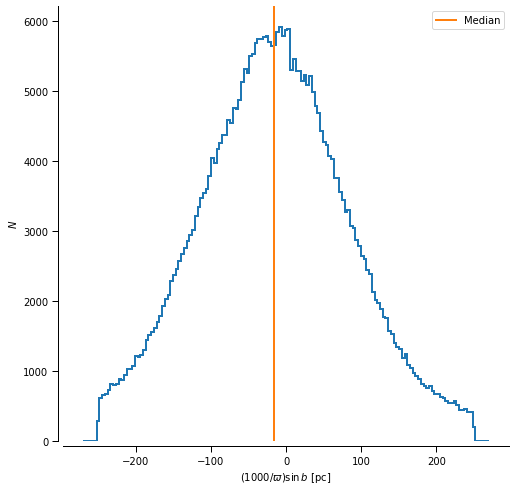

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(obatable['b']))*1000.0/obatable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-270,270])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

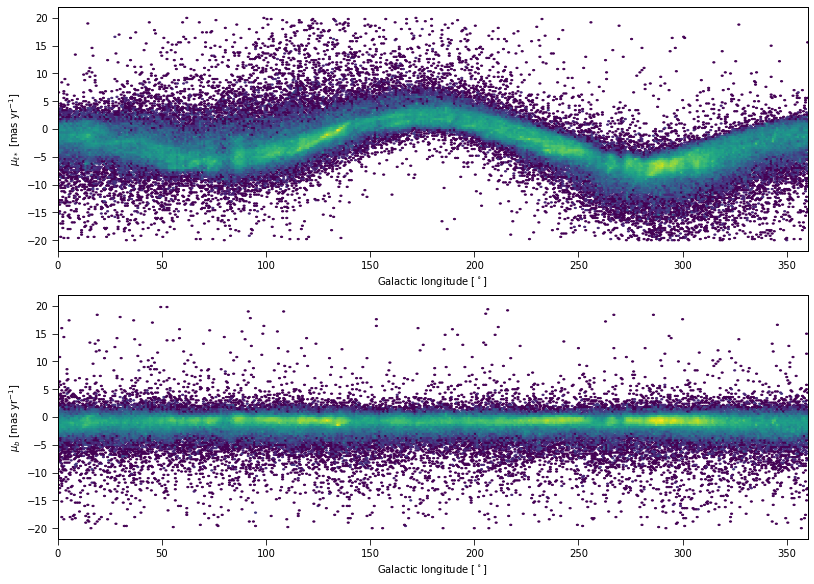

In [6]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

plt.savefig('imglinear/bstar-pml-pmb-vs-galon.png')

plt.show()

In [13]:
nsources = oba_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

oba_data = {'N': nsources, 
            'galon': np.deg2rad(oba_subsample['l']).tolist(), 
            'galat': np.deg2rad(oba_subsample['b']).tolist(),
            'pml_obs': oba_subsample['pml'].tolist(),
            'pml_obs_unc': oba_subsample['pml_error'].tolist(),
            'pmb_obs': oba_subsample['pmb'].tolist(),
            'pmb_obs_unc': oba_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': oba_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': oba_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun':zsun.value
            }
with open('oba.data.json', 'w') as fp:
    ujson.dump(oba_data, fp)
    fp.close()
    
constant_vcirc_model = {'stanfile':'mwdisk-constant-vcirc-model.stan', 
               'npars':6,
               'parnames':['Vcirc_sun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'Zsun', 'vdisp'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$Z_\odot$', r'$\sigma_v$'], 
               'inits':{'Vcirc_sun':220.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'Zsun':20.8, 'vdisp':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'Zsun':np.nan, 'vdisp':np.nan}
              }

declining_vcirc_model = {'stanfile':'mwdisk-declining-vcirc-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'Zsun', 'vdisp'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$Z_\odot$', r'$\sigma_v$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'Zsun':20.8, 'vdisp':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'Zsun':np.nan, 'vdisp':np.nan}
              }

declining_vcirc_disptens_model = {'stanfile':'mwdisk-declining-vcirc-disptens-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
              }

declining_vcirc_disptens_rsunfree_model = {'stanfile':'mwdisk-declining-vcirc-disptens-rsunfree-model.stan', 
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
              }

stan_model = declining_vcirc_disptens_model

distsunfree = False
if stan_model['stanfile'] == 'mwdisk-declining-vcirc-disptens-rsunfree-model.stan':
    distsunfree = True

Number of sources in sample: 20000


In [14]:
oba_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0'))
oba_data_path = os.path.join(os.getcwd(), 'oba.data.json')

nwarmup = 500
nsampling = 1000
nchains = 4

oba_model = CmdStanModel(stan_file=oba_stan)
oba_fit = oba_model.sample(chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=oba_data_path, save_warmup=False, show_progress=True)
#oba_fit = oba_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=oba_data_path, save_warmup=False, show_progress='notebook')

15:39:28 - cmdstanpy - INFO - compiling stan file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-declining-vcirc-disptens-model.stan to exe file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-declining-vcirc-disptens-model.exe
15:40:09 - cmdstanpy - INFO - compiled model executable: C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-declining-vcirc-disptens-model.exe
15:40:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:26:04 - cmdstanpy - INFO - CmdStan done processing.
17:26:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is -1.66262, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-declining-vcirc-disptens-model.stan', line 188, column 2 to column 54)
	Exception: mwdisk_declining_vcirc_disptens_model_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = -7.96755e-005, but dcov[2,1] = -0.000110877 (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-declining-vcirc-disptens-model.stan', line 157, column 2 to column 30)
	Exception: mwdisk_declining_vcirc_disptens_model_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = -7.96755e-005, but dcov[2,1] = -0.000110877 (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-declining-vcirc-disptens-model.stan', line 157, column 2 to column 30)
	Exception: mwdisk_declining_vcirc_disptens_model_model_namespace::log_prob: dcov is

In [15]:
oba_fit.summary()[0:stan_model['npars']+1]

Mean      MCSE    StdDev           5%          50%  \
lp__       -23547.70000  0.044773  1.938320 -23551.40000 -23547.30000   
Vcirc_sun     234.03900  0.007149  0.502244    233.21000    234.03700   
dVcirc_dVr     -3.44445  0.001356  0.095698     -3.60232     -3.44586   
Vsun_pec_x      8.08430  0.001841  0.135873      7.86651      8.08335   
Vsun_pec_y     11.28680  0.002390  0.172595     11.00650     11.28700   
Vsun_pec_z      8.16399  0.000741  0.053163      8.07642      8.16363   
vdispxy        14.15460  0.000958  0.073569     14.03470     14.15440   
vdispz          7.33559  0.000504  0.038371      7.27259      7.33548   

                    95%    N_Eff   N_Eff/s     R_hat  
lp__       -23545.20000  1874.21  0.231750  0.999883  
Vcirc_sun     234.86000  4935.66  0.610306  0.999669  
dVcirc_dVr     -3.28383  4979.93  0.615780  1.000220  
Vsun_pec_x      8.31340  5446.21  0.673435  0.999613  
Vsun_pec_y     11.57940  5215.96  0.644965  0.999906  
Vsun_pec_z      8.24967  5152.95  0.637173  1.000400  
vdispxy        14.27720  5895.29  0.728966  1.000720  
vdispz          7.39786  5802.90  0.717542  0.999678

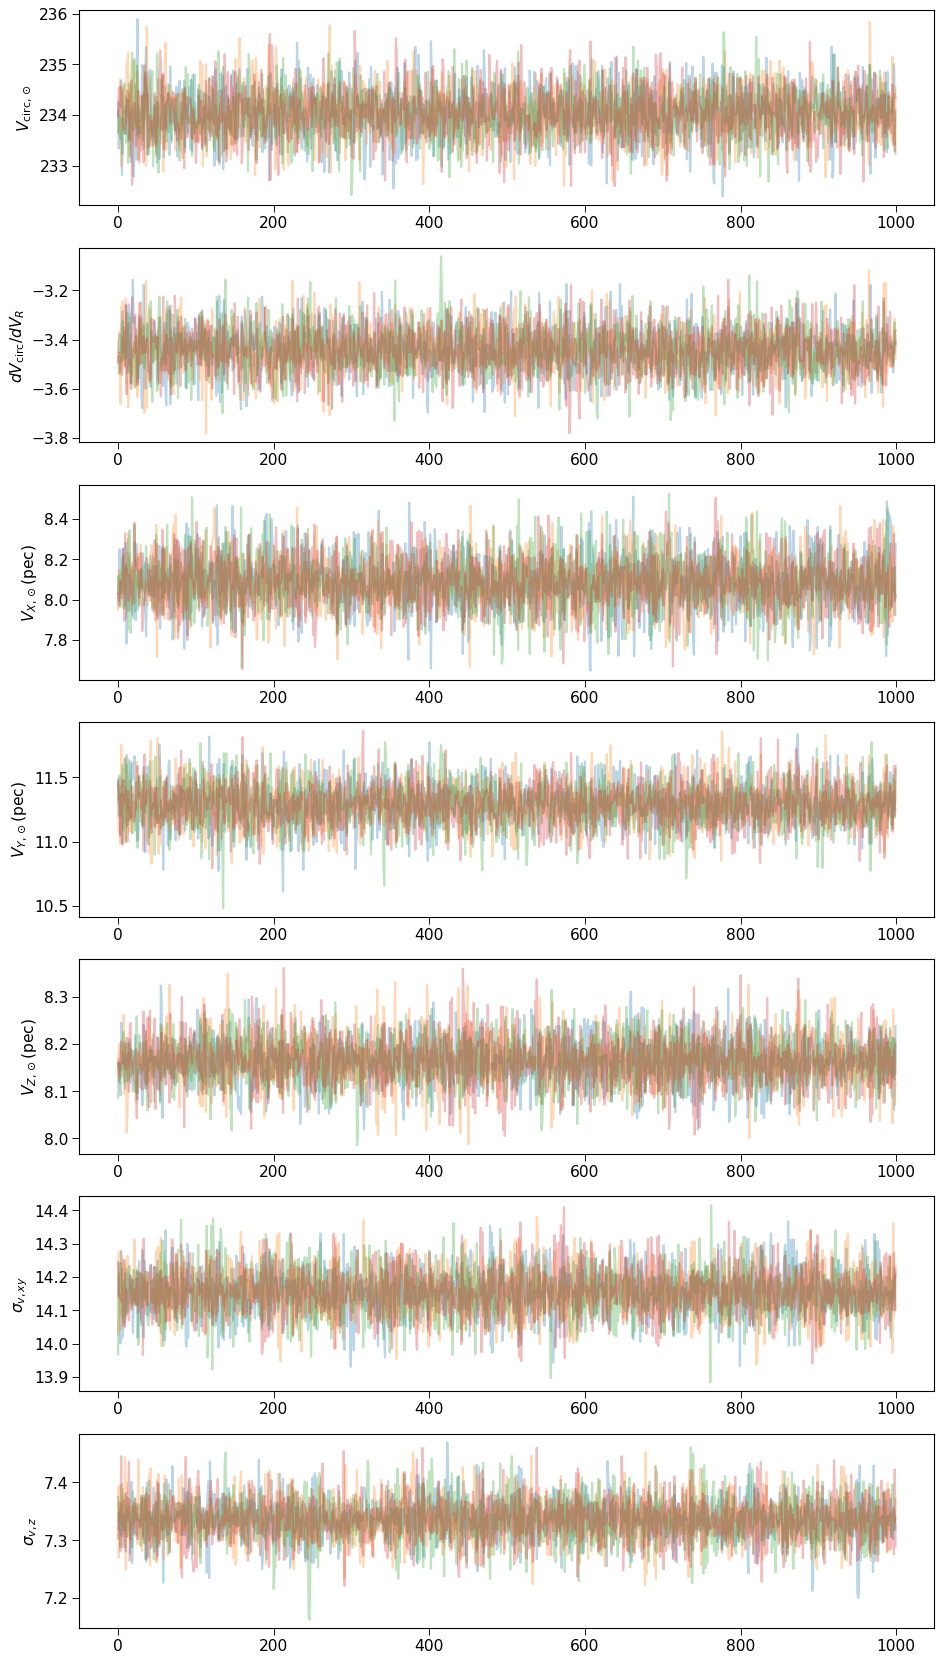

In [36]:
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

fig, axes = plt.subplots(ncols=1, nrows=stan_model['npars'], tight_layout=True, figsize=(12,3*stan_model['npars']))

for i, lab in zip(range(stan_model['npars']), stan_model['labels']):
    axes[i].plot(oba_fit.draws()[:,:,7+i], alpha=0.3)
    axes[i].set_ylabel(lab)

plt.savefig('imglinear/Traceplot_linear_B.png')
    
plt.show()

Vcirc_sun = 234.0+0.5-0.5
dVcirc_dVr = -3.4+0.1-0.1
Vsun_pec_x = 8.1+0.1-0.1
Vsun_pec_y = 11.3+0.2-0.2
Vsun_pec_z = 8.2+0.1-0.1
vdispxy = 14.2+0.1-0.1
vdispz = 7.3+0.0-0.0


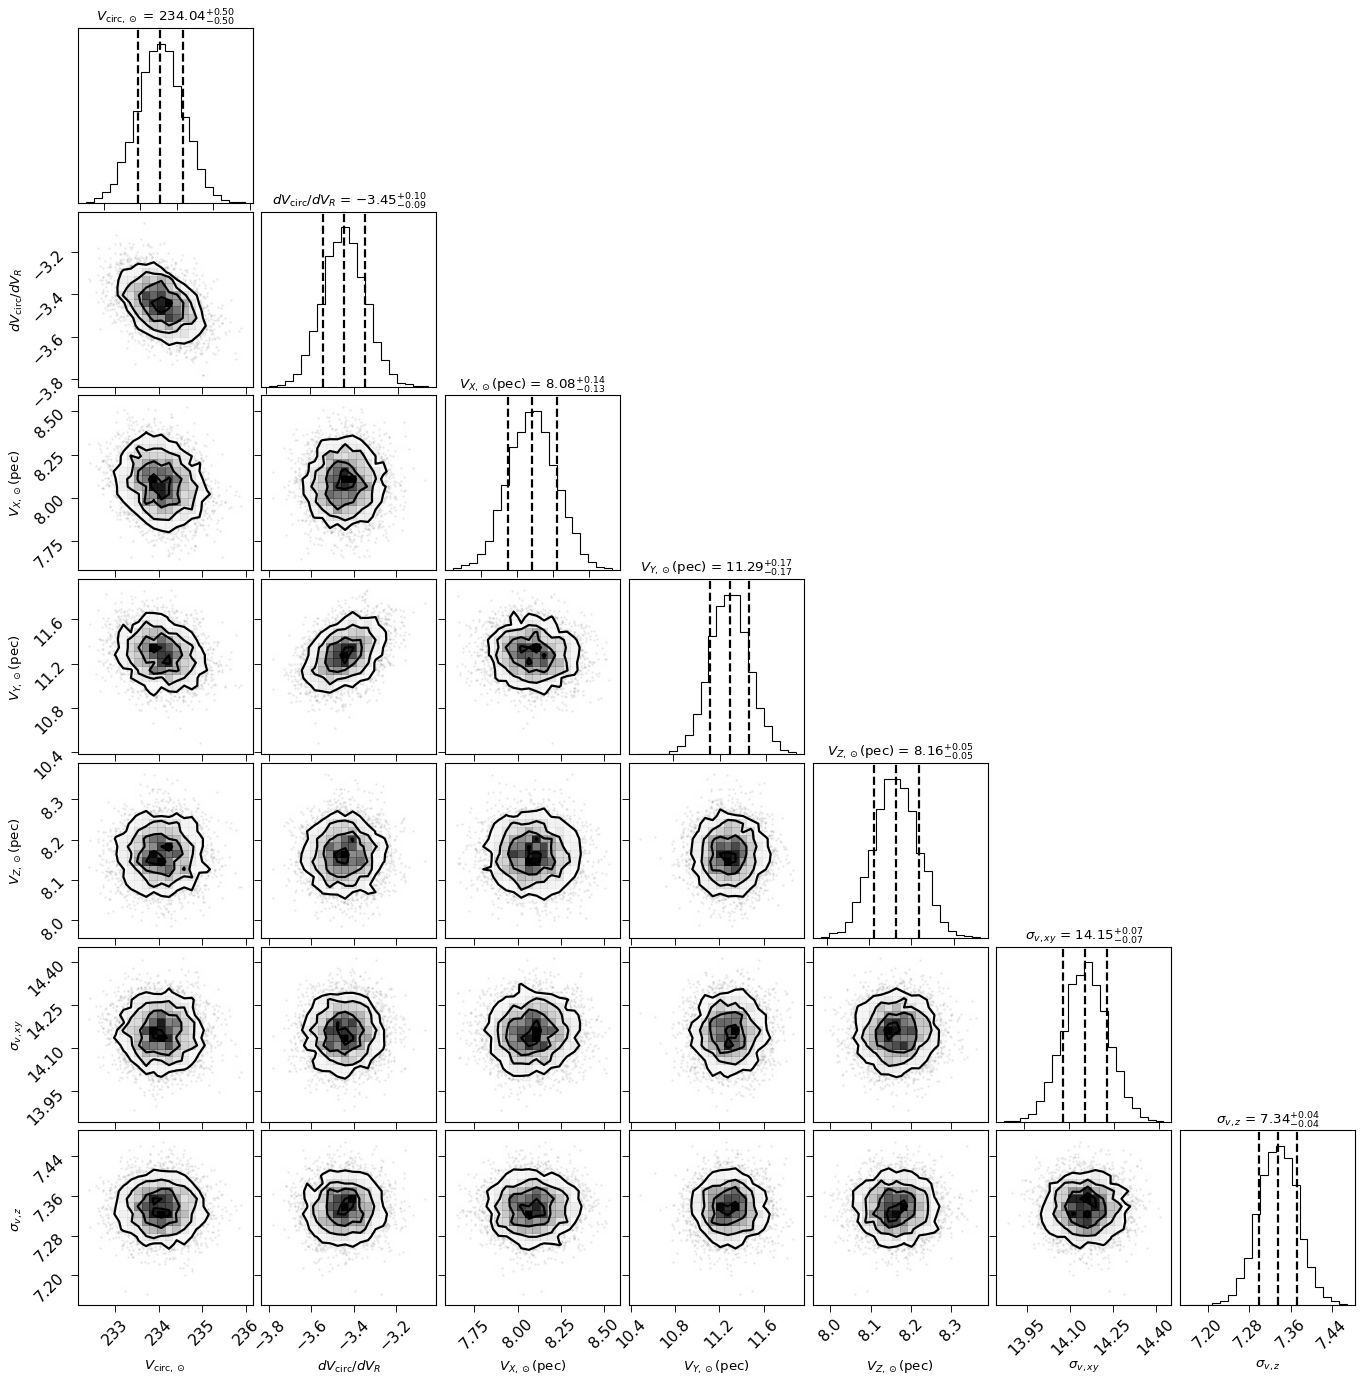

In [37]:
for par in stan_model['parnames']:
    vals = oba_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")
    
sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(oba_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()
                         
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.savefig('imglinear/corner_linear_B.png')
plt.show()

In [18]:
if distsunfree:
    Rsun = stan_model['best_params']['Rsun']*1000.0*u.pc
    
vsunx_samples = oba_fit.draws()[:,:,9].flatten()
vsuny_samples = oba_fit.draws()[:,:,10].flatten()+oba_fit.draws()[:,:,7].flatten()
vsunz_samples = oba_fit.draws()[:,:,11].flatten()
vsunvec_samples = np.vstack([vsunx_samples, vsuny_samples, vsunz_samples])

vsun_circ_samples = oba_fit.draws()[:,:,7].flatten()
slope_samples = oba_fit.draws()[:,:,8].flatten()

ra_sgr = (17.0+45.0/60.0+40.0409/3600.0)*15
dec_sgr = -29 - 28.118/2300
l_sgr, b_sgr = ct.transform_sky_coordinates(np.deg2rad(ra_sgr), np.deg2rad(dec_sgr))
print(np.rad2deg(l_sgr)-360, np.rad2deg(b_sgr))

p_sgr = np.array([-np.sin(l_sgr), np.cos(l_sgr), 0.0])
q_sgr = np.array([-np.sin(b_sgr)*np.cos(l_sgr), -np.sin(b_sgr)*np.sin(l_sgr), np.cos(b_sgr)])

mu_sgr_xy_samples = -np.dot(p_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
mu_sgr_z_samples = -np.dot(q_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
mu_sgr_xy = np.median(mu_sgr_xy_samples)
mu_sgr_xy_rse = rse(mu_sgr_xy_samples)
mu_sgr_z = np.median(mu_sgr_z_samples)
mu_sgr_z_rse = rse(mu_sgr_z_samples)

print(f"mu_sgr_xy = {mu_sgr_xy:.2f}  +/- {mu_sgr_xy_rse:.3f}")
print(f"mu_sgr_z = {mu_sgr_z:.2f}  +/- {mu_sgr_z_rse:.3f}")

oortA_samples = (vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
oortB_samples = (-vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
oortAminB_samples = oortA_samples - oortB_samples
oortA = np.median(oortA_samples)
oortA_rse = rse(oortA_samples)
oortB = np.median(oortB_samples)
oortB_rse = rse(oortB_samples)
oortAminB = np.median(oortAminB_samples)
oortAminB_rse = rse(oortAminB_samples)

print(f"Oort A = {oortA:.2f}  +/- {oortA_rse:.3f}")
print(f"Oort B = {oortB:.2f}  +/- {oortB_rse:.3f}")
print(f"Oort A-B = {oortAminB:.2f}  +/- {oortAminB_rse:.3f}")

-0.05951722261414716 -0.04846468783278978
mu_sgr_xy = -6.25  +/- 0.013
mu_sgr_z = -0.21  +/- 0.001
Oort A = 15.86  +/- 0.066
Oort B = -12.42  +/- 0.045
Oort A-B = 28.28  +/- 0.062


In [19]:
idata = az.from_cmdstanpy(
    posterior=oba_fit,
    posterior_predictive=['pred_pml', 'pred_pmb'],
    observed_data={'pml_obs': oba_data['pml_obs'],
                   'pmb_obs': oba_data['pmb_obs']},
    coords={'nsources': np.arange(oba_data['N'])},
    dims={
        'pml_obs': ['nsources'],
        'pmb_obs': ['nsources'],
        'pred_pml': ['nsources'],
        'pred_pmb': ['nsources'],
    },
)

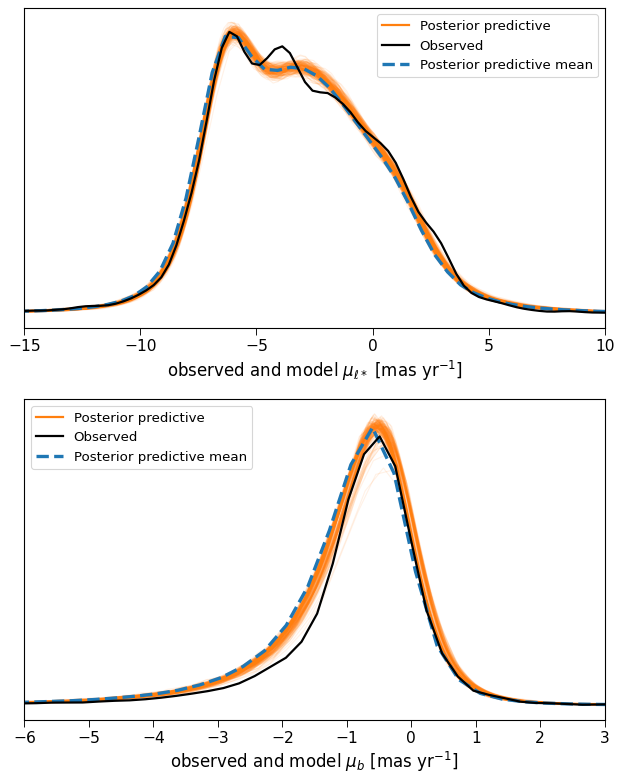

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2*5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pred_pml', 'pmb_obs':'pred_pmb'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    #apply_tufte(ax)
axes[0].set_xlim(-15,10)
axes[1].set_xlim(-6,3)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('imglinear/bstars_pms_posterior_predictive.png')

plt.show()

In [31]:
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.pc
vsunpeculiar = np.array([stan_model['best_params']['Vsun_pec_x'], stan_model['best_params']['Vsun_pec_y'], stan_model['best_params']['Vsun_pec_z']])*u.km/u.s
vcircsun = stan_model['best_params']['Vcirc_sun']
slope = stan_model['best_params']['dVcirc_dVr']

diskmodel = DiskKinematicModel(SlopedRotationCurve(vcircsun, Rsun.value/1000, slope), sunpos, vsunpeculiar)

In [30]:
print(sunpos)
print(vsunpeculiar)
print(vcircsun)
print(Rsun.value)
print(slope)

[-8277.     0.     0.] pc
[ 8.083335 11.28695   8.16355 ] km / s
234.037
8277.0
-3.4458650000000004


2155.9456645329547


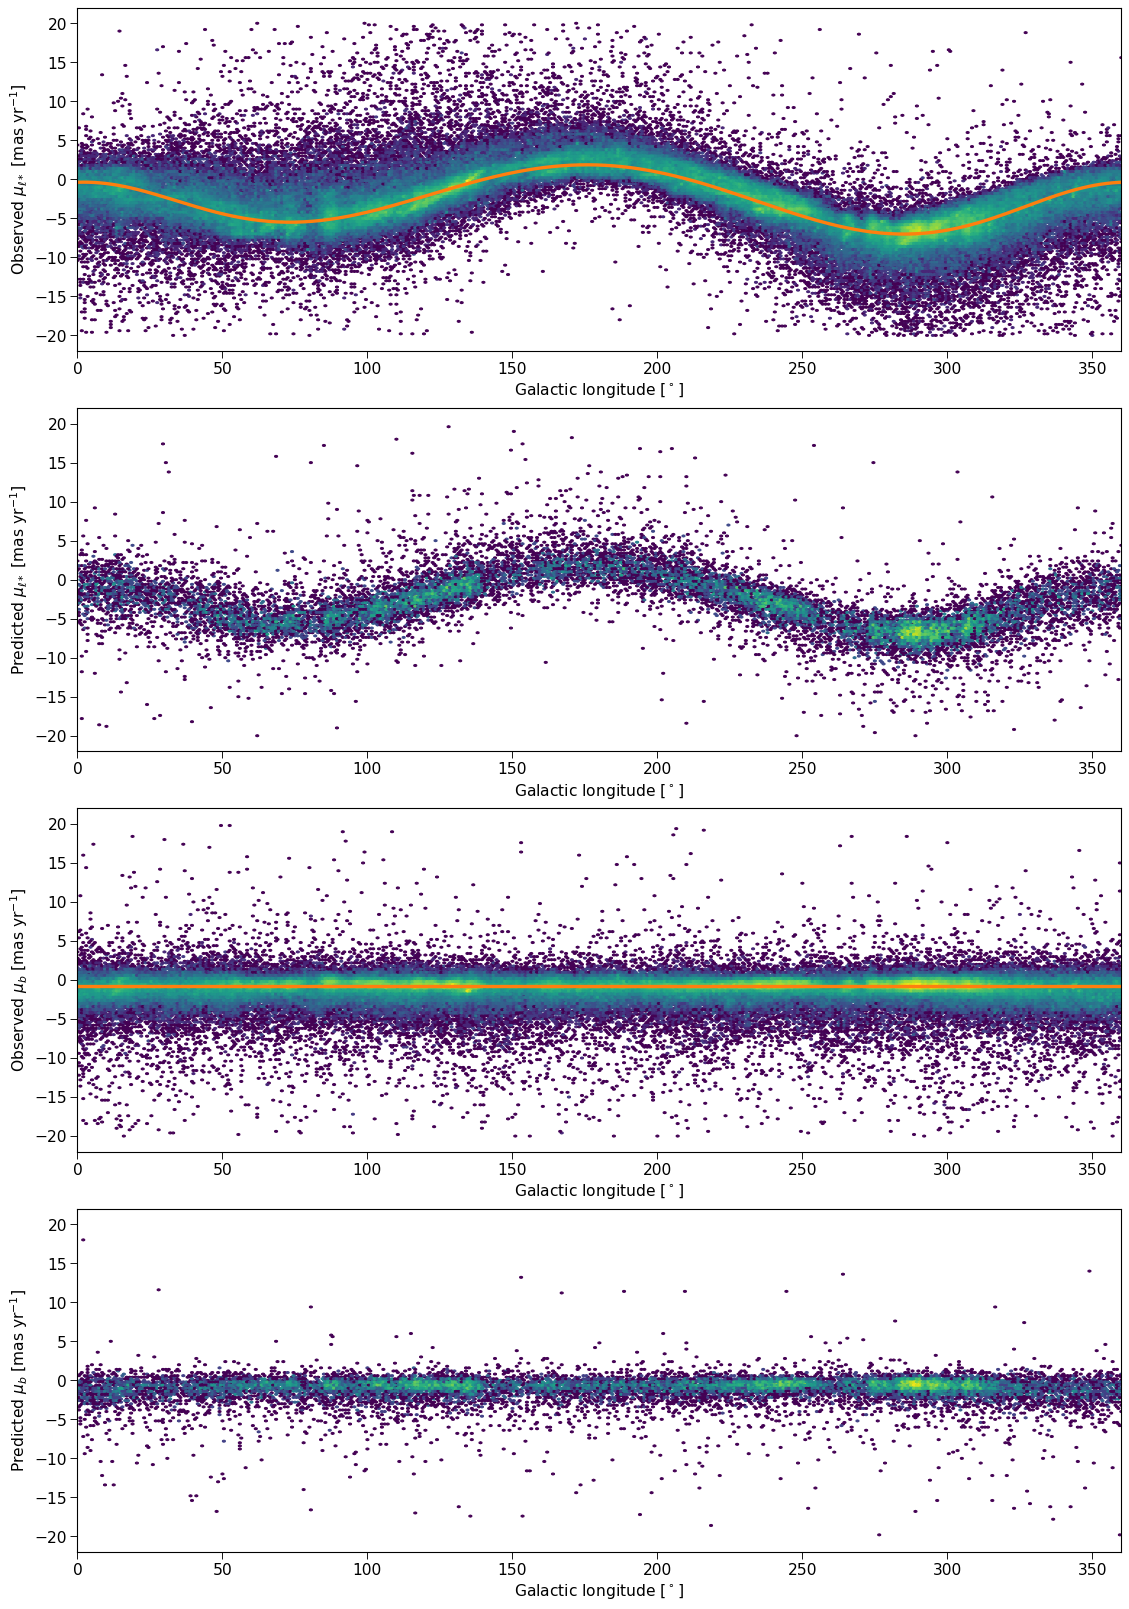

In [32]:
galon = np.linspace(0,360,361)*u.deg

median_dist = 1000/np.median(obatable['parallax'][sample_filter])
print(median_dist)

#pml_model, pmb_model, vrad_model = diskmodel_flat.observables(1000.0/obatable['parallax'][sample_filter].value*u.pc, 
#                                                              obatable['l'][sample_filter]*u.deg, obatable['b'][sample_filter]*u.deg)

chain = np.random.choice(nchains)
mcsample = np.random.choice(nsampling)

fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmul_model = fig.add_subplot(gs[1,0])
#im_lmul_model = ax_lmul_model.hexbin(obatable['l'][sample_filter], pml_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmul_model = ax_lmul_model.hexbin(oba_subsample['l'], idata.posterior_predictive['pred_pml'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_model.set_ylabel(r'Predicted $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul_model.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'Observed $\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

ax_lmub_model = fig.add_subplot(gs[3,0])
#im_lmub_model = ax_lmub_model.hexbin(obatable['l'][sample_filter], pmb_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmub_model = ax_lmub_model.hexbin(oba_subsample['l'], idata.posterior_predictive['pred_pmb'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_model.set_ylabel(r'Predicted $\mu_b$ [mas yr$^{-1}$]')
ax_lmub_model.set_xlim(0,360)

for dist in [median_dist]:
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, c='C1', lw=3)

plt.savefig('imglinear/Observations_and_posterior_predictive_mu_lb_vs_galon_linear_B.png')

plt.show()

2155.9456645329547


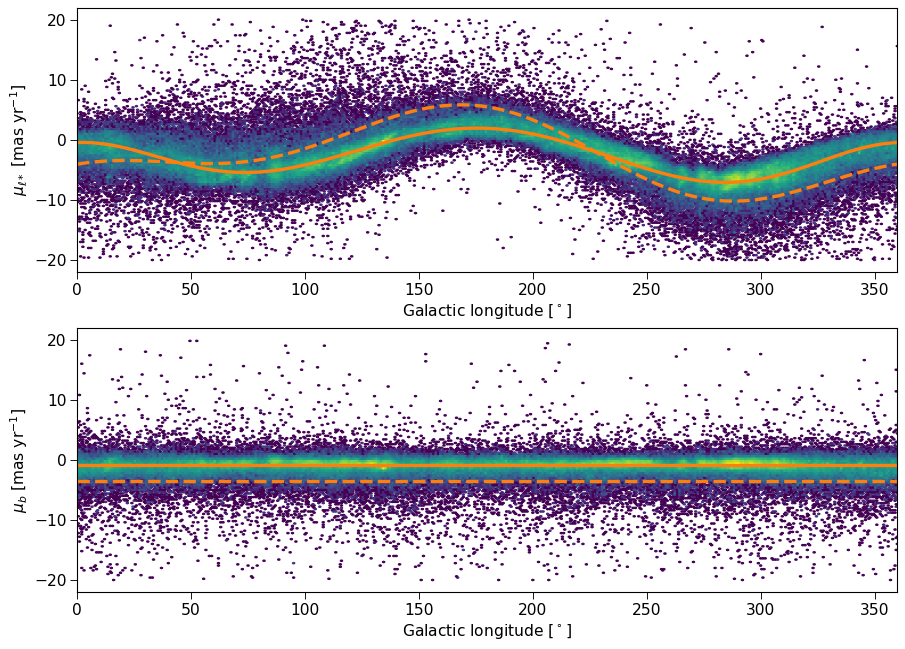

In [33]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

print(median_dist)
for dist, lstyle in zip([500, 2000], ['--C1', '-C1']):
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, lstyle, lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, lstyle, lw=3)

plt.savefig('imglinear/bstar-pml-pmb-vs-galon-plusmodel.png')

plt.show()

2155.9456645329547 pc


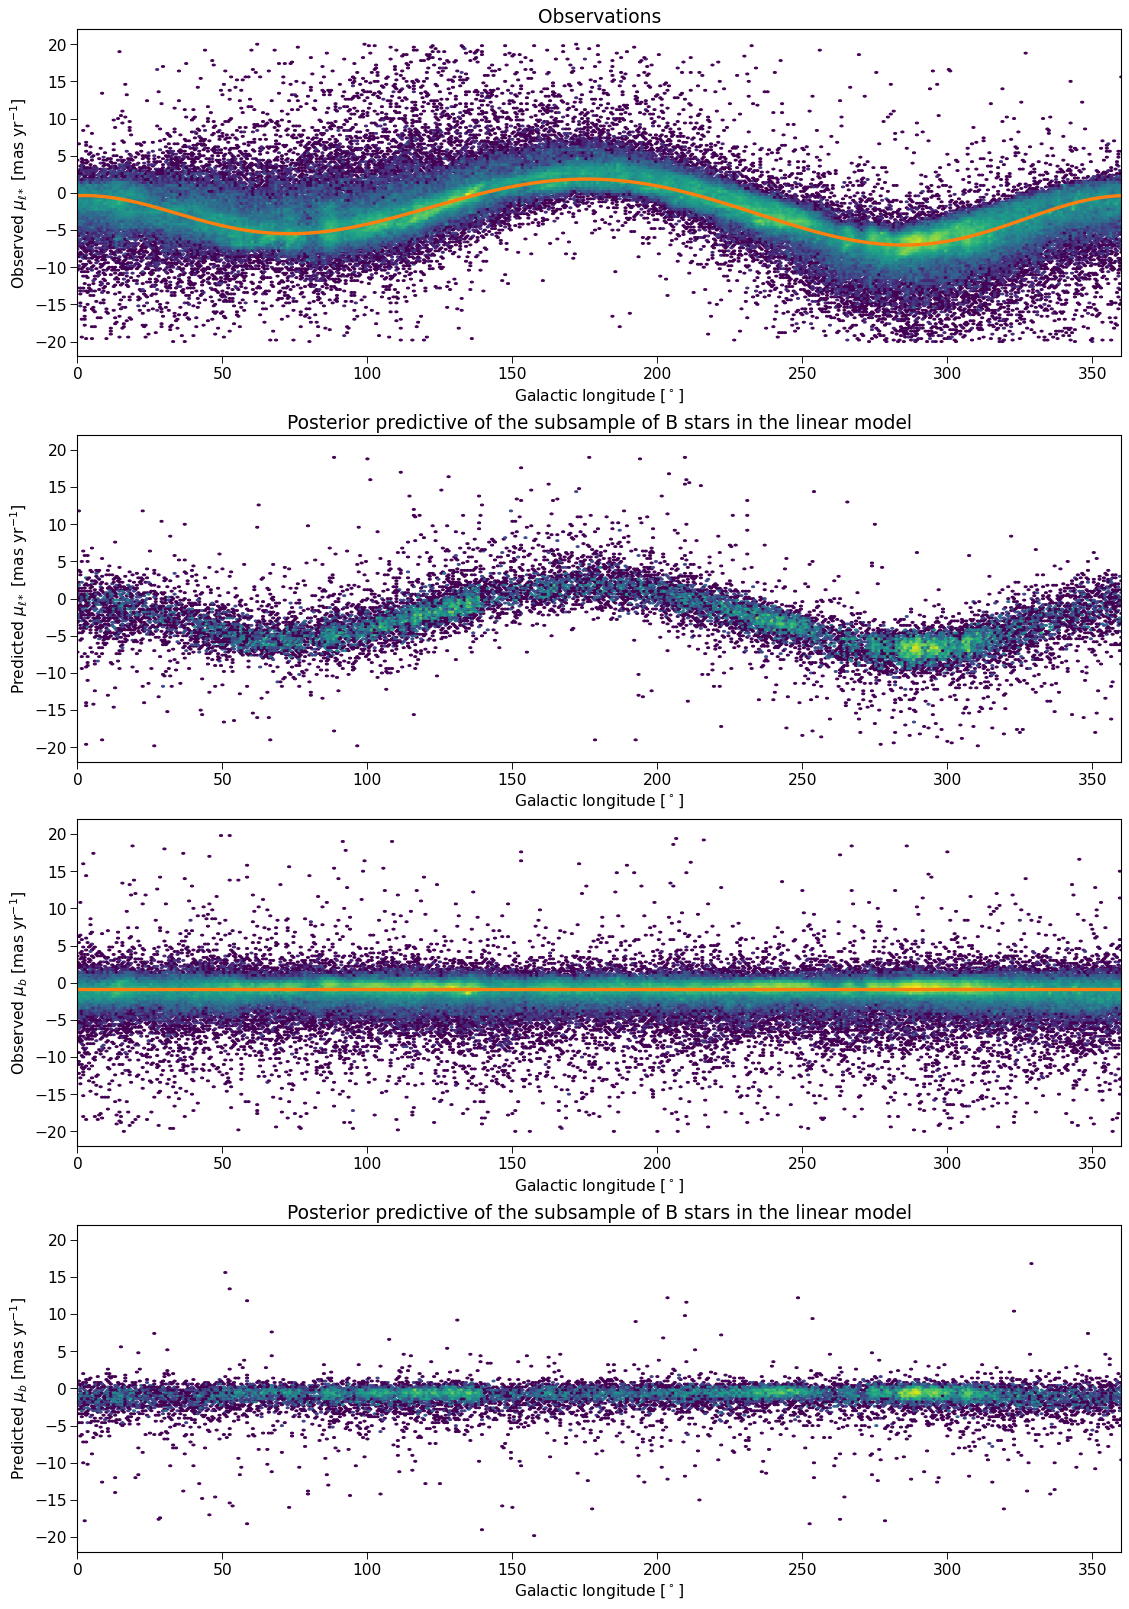

In [42]:
galon = np.linspace(0,360,361)*u.deg

median_dist = 1000/np.median(obatable['parallax'][sample_filter])
print(median_dist, 'pc')

#pml_model, pmb_model, vrad_model = diskmodel_flat.observables(1000.0/obatable['parallax'][sample_filter].value*u.pc, 
#                                                              obatable['l'][sample_filter]*u.deg, obatable['b'][sample_filter]*u.deg)

chain = np.random.choice(nchains)
mcsample = np.random.choice(nsampling)

fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)
ax_lmul.set_title("Observations for B stars in the linear model")

ax_lmul_model = fig.add_subplot(gs[1,0])
#im_lmul_model = ax_lmul_model.hexbin(obatable['l'][sample_filter], pml_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmul_model = ax_lmul_model.hexbin(oba_subsample['l'], idata.posterior_predictive['pred_pml'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
# im_lmul_model = ax_lmul_model.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
#                          gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20], alpha=0.05)
ax_lmul_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_model.set_ylabel(r'Predicted $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul_model.set_xlim(0,360)
ax_lmul_model.set_title("Posterior predictive of the subsample of B stars in the linear model")

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'Observed $\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)
ax_lmul.set_title("Observations")

ax_lmub_model = fig.add_subplot(gs[3,0])
#im_lmub_model = ax_lmub_model.hexbin(obatable['l'][sample_filter], pmb_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmub_model = ax_lmub_model.hexbin(oba_subsample['l'], idata.posterior_predictive['pred_pmb'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_model.set_ylabel(r'Predicted $\mu_b$ [mas yr$^{-1}$]')
ax_lmub_model.set_xlim(0,360)
ax_lmub_model.set_title("Posterior predictive of the subsample of B stars in the linear model")

for dist in [median_dist]:
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
#     ax_lmul.plot(galon, vrad_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, c='C1', lw=3)
#     ax_lmub.plot(galon, vrad_model, c='C1', lw=3)

plt.savefig('imglinear/Observations_and_posterior_predictive_mu_lb_vs_galon_linear_B.png')
plt.show()